In [1]:
### Modules
import pandas as pd
import numpy as np
import seaborn as sns
import re
import html.parser
import bs4

### Functions

# Clear Latin-1, ASCII, & Hex Chars
def clear_latin1_hex_chars(text):
  return re.sub(r'(\\x(.){2})', '', text)

# Remove HTML tags
def htmlparse(dataframe, text_column):
  dataframe[text_column] = dataframe[text_column].astype(str)
  # Extract any content found with HTML tags
  df = dataframe[text_column].apply(lambda x: bs4.BeautifulSoup(x, 'lxml').get_text())
  # Drop any duplicate values
  df = df.drop_duplicates()

  return df

# Extract mentions, urls, and hashtags
def get_extractions(df, text_column, URLPATTERN=r'(https?://\S+)'):
  # Quality control: ensure text column is type string
  df[text_column] = df[text_column].astype(str)

  # Create the following new columns from extractions
  df['mentions'] = df[text_column].str.findall(r'(?<=@)\w+').apply(','.join)
  df['hashtags'] = df[text_column].str.findall(r"#(\w+)").apply(','.join)
  df['URLs'] = df[text_column].apply(lambda x: re.findall(URLPATTERN, x))
  df['email_address'] = df[text_column].str.findall('(\S+@\S+)')

  return df

### Obtain & Scrub Data

In [20]:
# Import data
elon_tweet_data = pd.read_csv('elon_musk_data_image_too.csv')

elon_tweet_data.head()

id        created_at favorite_count retweet_count  \
0  1.46E+18  11/22/2021 21:40          36680          1112   
1  1.46E+18  11/22/2021 21:08           7275           347   
2  1.46E+18  11/22/2021 20:47           2688           164   
3  1.46E+18  11/22/2021 20:45           1857            70   
4  1.46E+18  11/22/2021 20:42          25946          1268   

                                           full_text image_urls  
0      @AshleyDCan And I will talk to their manager!        NaN  
1  @Rainmaker1973 The sheer physicality of change...        NaN  
2  @billhuang688 @teslaownersSV @boringcompany We...        NaN  
3  @mickakers @teslaownersSV @boringcompany Meant...        NaN  
4               @cleantechnica Transforming America!        NaN

In [16]:
elon_tweet_data.shape

(3483, 6)

##### Covert 'Created At', Sort on Date, and Check for Duplicate ID's

In [21]:
from datetime import datetime as dt

elon_tweet_data['created_at'] = pd.to_datetime(elon_tweet_data['created_at'], format='%m/%d/%Y %H:%M',errors='coerce')

# Drop NaT instances (8)
print('DF rows before dropping NAs: {}'.format(elon_tweet_data.shape[0]))
elon_tweet_data = elon_tweet_data.dropna(subset=['created_at'])
print('DF rows after dropping NAs: {}'.format(elon_tweet_data.shape[0]))
elon_tweet_data.dtypes

DF rows before dropping NAs: 3483
DF rows after dropping NAs: 3475


id                        object
created_at        datetime64[ns]
favorite_count            object
retweet_count             object
full_text                 object
image_urls                object
dtype: object

In [22]:
elon_tweet_data = elon_tweet_data.sort_values(by='created_at',ignore_index=True)

elon_tweet_data.head()

id          created_at favorite_count retweet_count  \
0  1.33131E+18 2020-11-24 18:54:00           1395            40   
1  1.33132E+18 2020-11-24 19:22:00           1097            21   
2  1.33132E+18 2020-11-24 19:23:00           3382            88   
3  1.33139E+18 2020-11-24 23:59:00          52615          2968   
4  1.33139E+18 2020-11-25 00:07:00           4555           145   

                                           full_text image_urls  
0  @StarshipFairing @MarcusHouseGame Not bad! We ...        NaN  
1          @RationalEtienne @MarcusHouseGame Not yet        NaN  
2  @Erdayastronaut @MarcusHouseGame Maybe start o...        NaN  
3  Good Starship SN8 static fire! Aiming for firs...        NaN  
4  @thesheetztweetz Lot of things need to go righ...        NaN

In [28]:
list_of_duplicates = elon_tweet_data.duplicated(keep='first')

elon_tweet_data_duplicated = elon_tweet_data[~list_of_duplicates]

elon_tweet_data_duplicated.head()

id          created_at favorite_count retweet_count  \
844  1.37565E+18 2021-03-27 03:34:00         572266         47221   
846  1.37566E+18 2021-03-27 03:48:00          28160           430   
848  1.37573E+18 2021-03-27 08:49:00          10459           845   
850  1.37591E+18 2021-03-27 20:34:00           3243           221   
852  1.37591E+18 2021-03-27 20:35:00           1842            65   

                                             full_text  \
844    Check out our new crane https://t.co/PE4vL6uKcb   
846                     @AstroJordy Haha actually true   
848  @cleantechnica This is crazy. Should use Tesla...   
850  @summerlinARK It�??s not really possible to ma...   
852                   @summerlinARK Sounds about right   

                                         image_urls  
844  http://pbs.twimg.com/media/ExdMlxuWYAEpSm1.jpg  
846                                             NaN  
848                                             NaN  
850                                             NaN  
852                                             NaN

In [29]:
elon_tweet_data_duplicated.tail()

id          created_at favorite_count retweet_count  \
1765  1.39398E+18 2021-05-16 17:34:00          20257          2703   
1766  1.39398E+18 2021-05-16 17:34:00          20257          2703   
1768  1.39399E+18 2021-05-16 18:07:00          15531          1983   
1769  1.39399E+18 2021-05-16 18:07:00          15531          1983   
1772  1.39399E+18 2021-05-16 18:17:00          39728          7331   

                                              full_text image_urls  
1765                        @michael_saylor Saylor Moon        NaN  
1766                        @michael_saylor Saylor Moon        NaN  
1768  @poisonouspinups @michael_saylor He should wea...        NaN  
1769  @poisonouspinups @michael_saylor He should wea...        NaN  
1772  @ChainLinkGod @PeterMcCormack Bitcoin is actua...        NaN

In [30]:
# Drop duplicates
elon_tweet_data = elon_tweet_data.drop_duplicates()

##### Remove Latin-1, ASCII & Hex characters

In [31]:
elon_tweet_data['full_text'] = elon_tweet_data['full_text'].apply(clear_latin1_hex_chars)

##### Remove HTML Tags

In [32]:
elon_tweet_data['full_text'] = htmlparse(elon_tweet_data, 'full_text')

C:\Users\User\anaconda3\lib\site-packages\bs4\__init__.py:417: MarkupResemblesLocatorWarning: "https://t.co/qbNT1dUsED" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\bs4\__init__.py:417: MarkupResemblesLocatorWarning: "https://t.co/sdmXKbHdzd" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\bs4\__init__.py:417: MarkupResemblesLocatorWarning: "https://t.co/EbOjGshvrq" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(
C:\Users\User\anaconda3\lib\

C:\Users\User\anaconda3\lib\site-packages\bs4\__init__.py:417: MarkupResemblesLocatorWarning: "https://t.co/g5ulISeWxS" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\bs4\__init__.py:417: MarkupResemblesLocatorWarning: "https://t.co/a0F22R5Hv7" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\bs4\__init__.py:417: MarkupResemblesLocatorWarning: "https://t.co/pCO0wNNZtz" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(
C:\Users\User\anaconda3\lib\

##### Extract Mentions, URLs, and Hashtags

In [33]:
elon_tweet_data = get_extractions(elon_tweet_data,'full_text')
elon_tweet_data.head()

id          created_at favorite_count retweet_count  \
0  1.33131E+18 2020-11-24 18:54:00           1395            40   
1  1.33132E+18 2020-11-24 19:22:00           1097            21   
2  1.33132E+18 2020-11-24 19:23:00           3382            88   
3  1.33139E+18 2020-11-24 23:59:00          52615          2968   
4  1.33139E+18 2020-11-25 00:07:00           4555           145   

                                           full_text image_urls  \
0  @StarshipFairing @MarcusHouseGame Not bad! We ...        NaN   
1          @RationalEtienne @MarcusHouseGame Not yet        NaN   
2  @Erdayastronaut @MarcusHouseGame Maybe start o...        NaN   
3  Good Starship SN8 static fire! Aiming for firs...        NaN   
4  @thesheetztweetz Lot of things need to go righ...        NaN   

                          mentions hashtags URLs email_address  
0  StarshipFairing,MarcusHouseGame            []            []  
1  RationalEtienne,MarcusHouseGame            []            []  
2   Erdayastronaut,MarcusHouseGame            []            []  
3                                             []            []  
4                  thesheetztweetz            []            []

In [40]:
# Write out partly cleaned file
elon_tweet_data.to_csv('elon_tweet_data_clean.csv',
                       index=True,
                       encoding='utf-8')

##### Extract Images from Tweets

In [5]:
# Import clean data
elon_tweet_data = pd.read_csv('elon_tweet_data_clean.csv')

In [6]:
# Subset rows with JPG urls
tweetImageURLs = elon_tweet_data.loc[~elon_tweet_data.image_urls.isnull(), ['id','image_urls']]

# Create column from index for filename
tweetImageURLs['index1'] = tweetImageURLs.index

tweetImageURLs.head()

id                                      image_urls  index1
55  1.336040e+18  http://pbs.twimg.com/media/EoqSQ1rUYAAW5tV.jpg      55
67  1.336830e+18  http://pbs.twimg.com/media/Eo1bXLlWEAIQR64.jpg      67
77  1.338370e+18  http://pbs.twimg.com/media/EpLUrc2W4AE3484.jpg      77
78  1.338380e+18  http://pbs.twimg.com/media/EpLd3knW4AArmU4.jpg      78
79  1.338480e+18  http://pbs.twimg.com/media/EpM_RypXMAEjbyC.jpg      79

In [7]:
import urllib.request

# Note: store the DataFrame index & the Twitter identifier in name (incase identifier idea fails)
for index in range(tweetImageURLs.shape[0]):
    urllib.request.urlretrieve(tweetImageURLs.image_urls.values[index],
                              f'images/{tweetImageURLs.index1.values[index]}.jpg')

### Process Images Found in Tweets

Note: Use Mode 7 from OpenCV Tesseract. This mode treats image as a single line of text

Additionally, this process requires the following configurations
 - Python 3.7.9
 - Tesseract 5.0.0
 - Pytesseract
 - Pillow
 - Matplotlib
 - OpenCV
 - Numpy

##### Configure Notebook for Image Processing

In [22]:
## Modules
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pytesseract

## Functions
def preprocess_images(im):
    im= cv2.bilateralFilter(im,5, 55,60)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    _, im = cv2.threshold(im, 240, 255, 1)
    return im

#change this path if you install pytesseract in another folder:
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'

##### Import Data and Sample Image

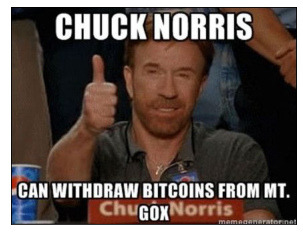

In [23]:
# Import clean data
elon_tweet_data = pd.read_csv('elon_tweet_data_clean.csv')

# Try on image 524
img = Image.open('images/524.jpg')

plt.imshow(img); plt.xticks([]); plt.yticks([])

# Convert image to np array
img = np.array(img)

##### Run a Tesseract Sample

In [24]:
# Preprocess Image
img_clean = preprocess_images(img)

text = pytesseract.image_to_string(img)
print('Before Cleaning Image: ', text.replace('\n', ' '))

text = pytesseract.image_to_string(img_clean)
print('After Cleaning Image: ', text.replace('\n', ' '))

Before Cleaning Image:  = «CAN WITHDRAW BITEOINS FROM MIT.  Ae ChugoxNorri:    
After Cleaning Image:  CHUCK NORRIS  CAN WITHDRAW BITCOINS FROM MT. GOX 


In [8]:
print(type(text))

<class 'str'>


##### Image Cleaning

For Image in Image Folder:
 1. Import Image
 2. Perform bilateral filter (sharpen edges of image)
 3. Project RGB images to grayscale
 4. Perform binarization transformation
 5. Extract text from image and create small dataframe with tweet id & new text

##### Scale Tesseract Solution

In [25]:
# Scan working directory's image folder for file names
# Note: filenames will be used to join extracted text to final dataframe

import os
import warnings

# Initialize image_text column in dataframe
elon_tweet_data['image_text'] = ''

# Suppress warnings
warnings.filterwarnings('ignore')

# test[0].replace('.jpg','')

for fname in os.listdir('images'):
    
    # Import image, store as numpy array (otherwise preprocessing function breaks)
    img = np.array(Image.open(f'images/{fname}'))
    
    # Clean image
    img_clean = preprocess_images(img)
    
    # Extract text
    image_content = pytesseract.image_to_string(img_clean)
    
    # Add text to dataframe column; match on index
    elon_tweet_data.loc[elon_tweet_data.index == int(fname.replace('.jpg','')), ['image_text']] = image_content.replace('\n', ' ')

In [26]:
elon_tweet_data.loc[~elon_tweet_data.image_urls.isnull(), ['image_text']].head()

image_text
55                                                   
67                                                   
77                  when you put he/him in ur bio    
78                    | WRG ARCS TERY Thinks about...
79  rcyperpunkgame 4 @ SS 06  Does anyone else jus...

In [27]:
# Write dataframe with processed images to file
# Write out partly cleaned file
elon_tweet_data.to_csv('elon_tweet_data_image_clean.csv',
                       index=False,
                       encoding='utf-8')

#### List of References

Cleaning Twitter Content<br>
https://towardsdatascience.com/extract-text-from-memes-with-python-opencv-tesseract-ocr-63c2ccd72b69

Extracting Image Content<br>
https://towardsdatascience.com/extract-text-from-memes-with-python-opencv-tesseract-ocr-63c2ccd72b69

Download Images from URL<br>
https://stackoverflow.com/questions/18408307/how-to-extract-and-download-all-images-from-a-website-using-beautifulsoup

Extract all images from webpage<br>
https://stackoverflow.com/questions/18408307/how-to-extract-and-download-all-images-from-a-website-using-beautifulsoup

Configuring Tesseract for Windows<br>
https://stackoverflow.com/questions/50951955/pytesseract-tesseractnotfound-error-tesseract-is-not-installed-or-its-not-i<br>
https://stackoverflow.com/questions/46140485/tesseract-installation-in-windows<br>
https://github.com/UB-Mannheim/tesseract/wiki

See Where Module Installed in Colab<br>
https://stackoverflow.com/questions/55974359/how-to-get-system-path-to-installed-packages-in-google-colab